# Модели финансовых рынков в дискретном времени


In [55]:
import yfinance as yf
import pandas as pd
import numpy as np 
from pylab import plt, mpl
import scipy.optimize as sco
import scipy.interpolate as sci
#import matplotlib as mpl
#import math

In [13]:
tickers = ['^GDAXI', 'MBG.DE', 'PUM.DE', 'BAYN.DE', 'PAH3.DE', 'HEN3.DE']
lst = []
for tick in tickers:
  data = yf.download(tick,'2021-01-01','2022-01-01')["Adj Close"].values
  lst.append(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
arr = np.array(lst)
df = pd.DataFrame(arr.T)
df.columns = tickers
df.head(5)

,^GDAXI,MBG.DE,PUM.DE,BAYN.DE,PAH3.DE,HEN3.DE
0,13726.740234,51.724777,90.166565,45.964359,53.227638,87.799614
1,13651.219727,51.715683,89.002235,46.136875,53.171036,85.497604
2,13891.969727,51.297523,89.239052,47.959969,52.737064,86.220551
3,13968.240234,52.533829,87.068260,48.789921,53.133301,86.011269
4,14049.530273,52.442921,87.423477,48.025249,52.548382,87.076668


Получим лог доходности:

In [15]:
mu_log = np.log(df / df.shift(1))
mu_log

,^GDAXI,MBG.DE,PUM.DE,BAYN.DE,PAH3.DE,HEN3.DE
0,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.005517,-0.000176,-0.012997,0.003746,-0.001064,-0.026569
2,0.017482,-0.008119,0.002657,0.038754,-0.008195,0.008420
3,0.005475,0.023815,-0.024626,0.017157,0.007485,-0.002430
4,0.005803,-0.001732,0.004071,-0.015797,-0.011070,0.012311
...,...,...,...,...,...,...
250,0.010389,0.005723,0.004746,0.019382,0.020802,0.006818
251,0.004998,-0.002858,0.000473,0.009924,-0.000947,0.005928
252,0.008079,-0.004158,0.010826,0.001273,0.002838,0.008687
253,-0.007006,-0.019880,0.002338,-0.004251,-0.012118,-0.000558


Частотное распределение логарифмических доходностей: 

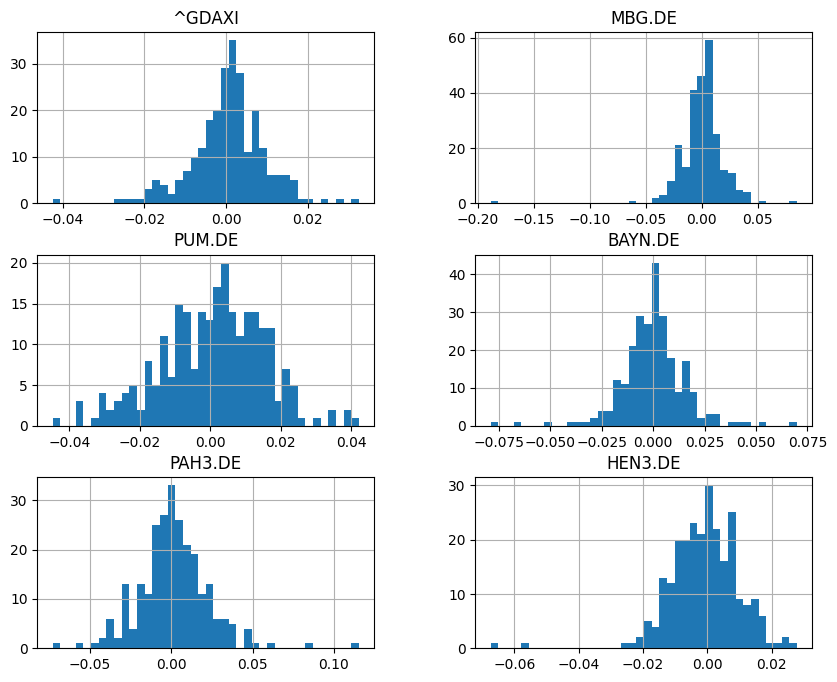

In [18]:
mu_log.hist(bins = 40, figsize = (10,8));

Ковариационная матрица при применении коэффициента масштабирования:

In [19]:
mu_log.mean()*252 # среднегодовая доходность 

^GDAXI     0.144871
MBG.DE     0.188588
PUM.DE     0.162993
BAYN.DE   -0.009953
PAH3.DE    0.412215
HEN3.DE   -0.239614
dtype: float64

In [20]:
mu_log.cov()*252 # годовая ковариационная матрица

,^GDAXI,MBG.DE,PUM.DE,BAYN.DE,PAH3.DE,HEN3.DE
^GDAXI,0.020788,0.024631,0.016765,0.017822,0.027719,0.012392
MBG.DE,0.024631,0.108590,0.010727,0.024030,0.052628,0.014927
PUM.DE,0.016765,0.010727,0.055521,0.009530,0.022650,0.008466
BAYN.DE,0.017822,0.024030,0.009530,0.062421,0.022473,0.015254
PAH3.DE,0.027719,0.052628,0.022650,0.022473,0.116782,0.017965
HEN3.DE,0.012392,0.014927,0.008466,0.015254,0.017965,0.029930


Допустим, что инвестору разрешено открывать только длинные позиции

In [22]:
weights = np.random.random(n)   # случ.веса инстурементов в портфеле
weights /= np.sum(weights)     # нормализуемые от 1 до 100% 
print('рандомизированные веса:', weights)

рандомизированные веса: [0.07764747 0.17184611 0.03774871 0.29286596 0.25351339 0.16637835]


In [23]:
weights.sum()

1.0

Годовая доходность и волатильность портфеля с учетом весов: 

In [24]:
mu_m = np.sum(mu_log.mean() * weights) * 252
sigma_m = (np.dot(weights.T, np.dot(mu_log.cov() * 252, weights))) **0.5

print('mu_m = ', round(mu_m,4), '\nsigma_m = ', round(sigma_m,4), '\nvar_m = ', round(sigma_m**2,4))

mu_m =  0.1115 
sigma_m =  0.1875 
var_m =  0.0352


# Метод Монте-Карло

In [25]:
def port_mu(weights):
  return np.sum(mu_log.mean() * weights) * 252

def port_vol(weights):
  return np.sqrt(np.dot(weights.T, np.dot(mu_log.cov() * 252, weights)))

In [26]:
p_mu, p_vol = [], []

for p in range(2500):
  weights = np.random.random(n)
  weights /= np.sum(weights)
  p_mu.append(port_mu(weights))
  p_vol.append(port_vol(weights))

p_mu = np.array(p_mu)
p_vol = np.array(p_vol)

print('ожидаемая доходность:', p_mu,
      '\n волатильность:', p_vol)

ожидаемая доходность: [0.05177006 0.15536975 0.05446374 ... 0.04553351 0.09288106 0.10081923] 
 волатильность: [0.17265676 0.20585702 0.14506722 ... 0.1802852  0.16900714 0.17979494]


# Шкала коэффициента Шарпа:

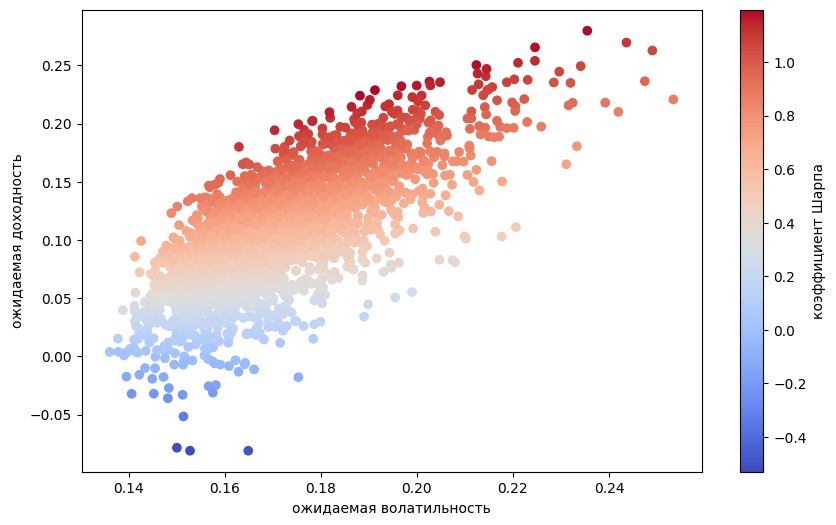

In [29]:
plt.figure(figsize = (10,6))
plt.scatter(p_vol, p_mu, c = p_mu / p_vol, marker = 'o', cmap = 'coolwarm')
plt.xlabel('ожидаемая волатильность')
plt.ylabel('ожидаемая доходность')
plt.colorbar(label = 'коэффициент Шарпа');

Таким образом, не всякое распределение весов дает хорошие результаты. С точки зрения инвестора, наиболее привлекательными выглядят портфели с максимальной доходностью для фиксированного уровня риска или с наименьшим уровнем риска для
фиксированной ожидаемой доходности. Такой набор портфелей составляет так
называемую границу эффективности.

# Максимизация коэффициента Шарпа

Для получения максимальной доходности и
оптимального состава инвестиционного портфеля нужно минимизировать
отрицательные значения коэффициента Шарпа

In [34]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(n))

In [35]:
def min_func_sharpe(weights):         
  return - port_mu(weights) / port_vol(weights)    

In [36]:
eweights = np.array(n * [1/n])       # вектор равных весов
eweights

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [37]:
min_func_sharpe(eweights)

-0.6624241925740914

# Оптимальный состав портфеля opts: 

In [46]:
%%time
opts = sco.minimize(min_func_sharpe, n*[1./n], method = 'SLSQP', 
                    bounds = bnds, constraints = cons)

opts

CPU times: user 146 ms, sys: 0 ns, total: 146 ms
Wall time: 178 ms


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.2882754794540443
       x: [ 3.908e-01  0.000e+00  1.724e-01  1.076e-16  4.368e-01
            7.427e-17]
     nit: 10
     jac: [ 2.998e-04  1.335e-01  4.622e-04  6.103e-01 -4.507e-04
            1.597e+00]
    nfev: 72
    njev: 10

In [44]:
print('оптимальные веса: ', opts['x'].round(3))
print('результирующая доходность: ', port_mu(opts['x']).round(3))
print('результирующая волатильность: ', port_vol(opts['x']).round(3))
print('макс коэф Шарпа: ', port_mu(opts['x']) / port_vol(opts['x']).round(3))

оптимальные веса:  [0.391 0.    0.172 0.    0.437 0.   ]
результирующая доходность:  0.265
результирующая волатильность:  0.206
макс коэф Шарпа:  1.2852848386232103


# Минимизируем дисперсию (оптимизацией) optv: 

In [47]:
%%time
optv = sco.minimize(port_vol, eweights, method = 'SLSQP', 
                    bounds = bnds, constraints = cons)

optv  

CPU times: user 44.6 ms, sys: 0 ns, total: 44.6 ms
Wall time: 52.5 ms


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.1328512634174077
       x: [ 5.560e-01  6.505e-19  9.601e-02  3.252e-02  1.475e-17
            3.155e-01]
     nit: 10
     jac: [ 1.329e-01  1.522e-01  1.327e-01  1.330e-01  1.805e-01
            1.328e-01]
    nfev: 70
    njev: 10

In [48]:
print('оптимальные веса: ', optv['x'].round(3))
print('результирующая доходность: ', port_mu(optv['x']).round(3))
print('результирующая волатильность: ', port_vol(optv['x']).round(3))
print('макс коэф Шарпа: ', port_mu(optv['x']) / port_vol(optv['x']).round(3))

оптимальные веса:  [0.556 0.    0.096 0.033 0.    0.315]
результирующая доходность:  0.02
результирующая волатильность:  0.133
макс коэф Шарпа:  0.15245000922871754


В портфеле остаются 4 из 6 фин.инструментов (исключаются 'MBG.DE' и 'PAH3.DE') и так достигается минимальная волатильность портфеля

# Нахождение всех возможных оптимальных портфелей 


In [49]:
cons = ({'type': 'eq', 'fun': lambda x: port_mu(x) - tret},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

bnds = tuple((0,1) for x in weights)

In [50]:
%%time
trets = np.linspace(0.05, 0.2, 50)  # равномерно распределенные уровни доходности
tvols = []

# минимизация волатильности портфеля для разных целевых уровней доходности: 
for tret in trets:
  res = sco.minimize(port_vol, eweights, method = 'SLSQP', 
                     bounds = bnds, constraints = cons)
  tvols.append(res['fun'])

tvols = np.array(tvols)
tvols

CPU times: user 3.82 s, sys: 10.6 ms, total: 3.83 s
Wall time: 4.12 s


array([0.1334304 , 0.13355465, 0.13369085, 0.13383898, 0.133999  ,
       0.13417086, 0.13435454, 0.13455011, 0.13475746, 0.13497572,
       0.13520605, 0.13544789, 0.13570119, 0.1359664 , 0.13624199,
       0.13652919, 0.13682782, 0.13713736, 0.13745802, 0.13778965,
       0.13813217, 0.13848549, 0.13884954, 0.13922429, 0.13960986,
       0.14000522, 0.14041134, 0.14082778, 0.14125452, 0.14169162,
       0.14213907, 0.14259475, 0.14309675, 0.14370763, 0.14438897,
       0.14514066, 0.14596146, 0.14685008, 0.14780533, 0.14882593,
       0.14991052, 0.15105777, 0.15226627, 0.15353451, 0.15486108,
       0.15624448, 0.1576832 , 0.15917574, 0.16072058, 0.16231629])

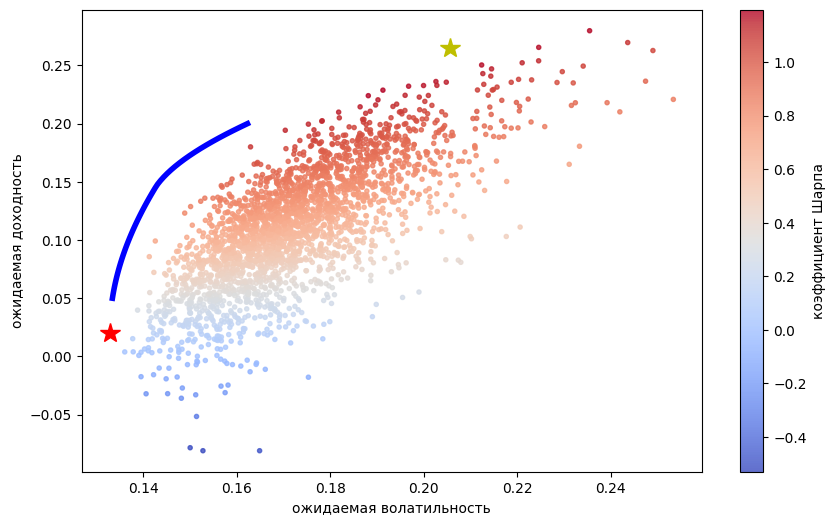

In [51]:
plt.figure(figsize = (10,6))
plt.scatter(p_vol, p_mu, c = p_mu / p_vol, 
            marker = '.', alpha = 0.8, cmap = 'coolwarm')

plt.plot(tvols, trets, 'blue', lw = 4.0)  # оптимальные портфели 

# портфель с максимальным коэффициентом Шарпа: 
plt.plot(port_vol(opts['x']), port_mu(opts['x']), 'y*', markersize = 15.0)

# портфель с минимальной волатильностью (дисперсией): 
plt.plot(port_vol(optv['x']), port_mu(optv['x']), 'r*', markersize = 15.0)

plt.xlabel('ожидаемая волатильность')
plt.ylabel('ожидаемая доходность')
plt.colorbar(label = 'коэффициент Шарпа');

Видим, что оптимальных портфелей немного

In [52]:
# портфель с максимальным коэффициентом Шарпа: 
print('x_Шарпа =', port_vol(opts['x']), '   y_Шарпа = ', port_mu(opts['x']))

x_Шарпа = 0.20552178550241995    y_Шарпа =  0.2647686767563813


In [53]:
# портфель с минимальной волатильностью (дисперсией):
print('x_мин_вол =', port_vol(optv['x']), '   y_мин_вол = ', port_mu(optv['x']))

x_мин_вол = 0.1328512634174077    y_мин_вол =  0.020275851227419435


# Выбор оптимального портфеля среди эффективных

In [57]:
ind = np.argmin(tvols)   # индекс портфеля с мин волатильностью 
evols = tvols[ind:]
erets = trets[ind:]

# интерполяция кубическими сплайнами по указанным значениям: 
tck = sci.splrep(evols, erets)

In [58]:
# функция границы эффективности (аппроксимация сплайнами):
def f(x):
  return sci.splev(x, tck, der = 0)

# первая производная функции границы эффективности: 
def df(x):
  return sci.splev(x, tck, der = 1)

In [59]:
# функция описывает систему уравнения и начальный набор параметров: 
def equations(p, mu_f = 0.01):
  eq1 = mu_f - p[0]
  eq2 = mu_f + p[1]*p[2] - f(p[2])
  eq3 = p[1] - df(p[2])
  return eq1, eq2, eq3

In [60]:
# решение СУ для заданных начальных параметров:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])
opt

/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([0.01      , 1.69555557, 0.17257066])

In [61]:
# все решения уравнения равны нулю
np.round(equations(opt), 6)

array([ 0.      ,  0.084454, -0.014594])

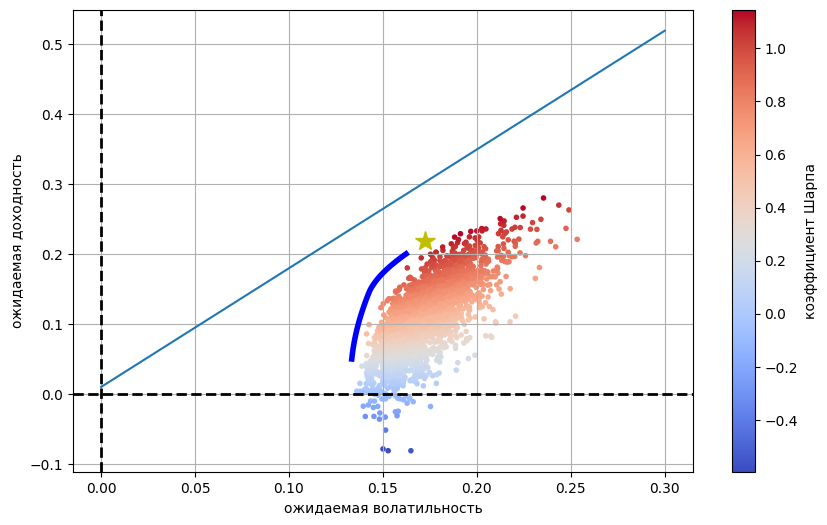

In [62]:
plt.figure(figsize = (10,6))
plt.scatter(p_vol, p_mu, c = (p_mu - 0.01) / p_vol, 
            marker = '.', cmap = 'coolwarm')

plt.plot(evols, erets, 'blue', lw = 4.0)  # эффективная граница
cx = np.linspace(0.0, 0.3)

plt.plot(cx, opt[0] + opt[1]*cx, lw = 1.5)   # CML
plt.plot(opt[2], f(opt[2]), 'y*', markersize = 15.0)

plt.grid(True)
plt.axhline(0, color = 'k', ls = '--', lw = 2.0)
plt.axvline(0, color = 'k', ls = '--', lw = 2.0)

plt.xlabel('ожидаемая волатильность')
plt.ylabel('ожидаемая доходность')
plt.colorbar(label = 'коэффициент Шарпа');

Рассчитаем веса фин инструментов в оптимальном портфеле (для трех из 4): 

In [63]:
cons = ({'type': 'eq', 'fun': lambda x: port_mu(x) - f(opt[2])},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# предельные значения параметров: 
bnds = tuple((0,1) for x in weights)

res = sco.minimize(port_vol, eweights, method = 'SLSQP', 
                     bounds = bnds, constraints = cons)

res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.17274187663678606
       x: [ 5.918e-01  2.082e-17  1.439e-01  0.000e+00  2.643e-01
            1.041e-17]
     nit: 7
     jac: [ 1.276e-01  1.738e-01  1.383e-01  1.034e-01  2.925e-01
            7.700e-02]
    nfev: 49
    njev: 7

In [64]:
print('веса фин инструментов: ', res['x'].round(3))
print('результирующая доходность: ', port_mu(res['x']).round(3))
print('результирующая волатильность: ', port_vol(res['x']).round(3))
print('макс коэф Шарпа: ', (port_mu(res['x']) / port_vol(res['x'])).round(3))

веса фин инструментов:  [0.592 0.    0.144 0.    0.264 0.   ]
результирующая доходность:  0.218
результирующая волатильность:  0.173
макс коэф Шарпа:  1.263


In [65]:
tickers

['^GDAXI', 'MBG.DE', 'PUM.DE', 'BAYN.DE', 'PAH3.DE', 'HEN3.DE']

Так, из 6 фин.инструментов оптимальный портфель составят только три: ['^GDAXI', 'PUM.DE',  'PAH3.DE']

# Байесовская статистика 

In [101]:
tickers = ['PUM.DE', 'PAH3.DE']
lst = []
for tick in tickers:
  data = yf.download(tick,'2021-01-01','2022-01-01')["Adj Close"].values
  lst.append(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [104]:
# добавим даты 
sd = yf.download('PUM.DE','2021-01-01','2022-01-01')
data_ind = sd.index.tolist()

df.index = list(data_ind)
df

[*********************100%***********************]  1 of 1 completed


,PUM.DE,PAH3.DE
2021-01-04,90.166565,53.227638
2021-01-05,89.002235,53.171036
2021-01-06,89.239052,52.737064
2021-01-07,87.068260,53.133301
2021-01-08,87.423477,52.548382
...,...,...
2021-12-23,104.387749,81.689400
2021-12-27,104.437180,81.612083
2021-12-28,105.573982,81.844040
2021-12-29,105.821114,80.858208


In [105]:
dfn = np.log(df / df.shift(1))
dfn

,PUM.DE,PAH3.DE
2021-01-04,NaN,NaN
2021-01-05,-0.012997,-0.001064
2021-01-06,0.002657,-0.008195
2021-01-07,-0.024626,0.007485
2021-01-08,0.004071,-0.011070
...,...,...
2021-12-23,0.004746,0.020802
2021-12-27,0.000473,-0.000947
2021-12-28,0.010826,0.002838
2021-12-29,0.002338,-0.012118


In [106]:
dfn.corr()

,PUM.DE,PAH3.DE
PUM.DE,1.000000,0.281287
PAH3.DE,0.281287,1.000000


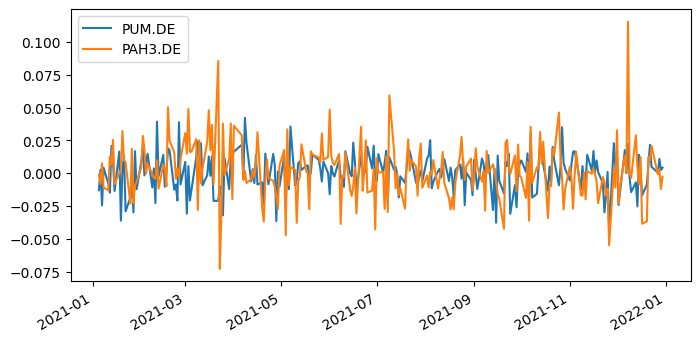

In [107]:
dfn.plot(figsize = (8,4));

Диаграмма рассеивания:

In [108]:
dfn.index

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
               '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', length=255, freq=None)

In [112]:
mpl_dates = mpl.dates.date2num(dfn.index.to_pydatetime())

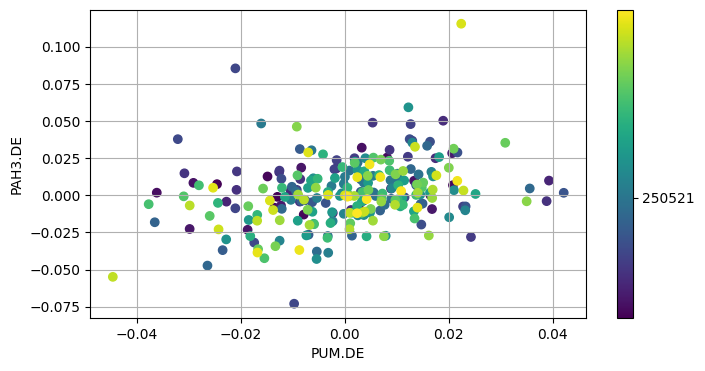

In [114]:
plt.figure(figsize = (8,4))

plt.scatter(dfn['PUM.DE'], dfn['PAH3.DE'], c = mpl_dates, marker = 'o')
plt.grid(True)
plt.xlabel('PUM.DE')
plt.ylabel('PAH3.DE')

plt.colorbar(ticks = mpl.dates.DayLocator(interval = 250),
             format = mpl.dates.DateFormatter('%d%m%y'));